# 3. 什么是CAPM模型？
*Alpha与Beta模型*

## 目录
1. Alpha与Beta分别是什么？
2. CAPM是什么？
3. 如何计算股票与大盘的相关性？
4. 如何用图形显示CAPM模型？
5. 如何对模型做方差分析？

## Alpha与Beta分别是什么？

Alpha指的是投资者所获得的超额回报，即高于或低于其业绩基准的市场指数。
Beta是一种衡量风险的方法，可以应用于个股或股票投资组合。Beta系数较高的股票通常会对市场或宏观经济新闻具有更加不稳定的波动。

### Beta算法：

$B_x = \frac{\sigma_{x,m}}{\sigma^2_m}$

$P_{x,m} = \frac{\sigma_{x,m}}{\sigma_x\sigma_m}$

$B_x=p_{x,m}*\frac{\sigma_x}{\sigma_m}$

## CAPM模型是什么？
CAPM模型公式：

$R_x-R_f=a_x+B_x(R_m-R_f)+\epsilon$

## 如何计算股票与大盘的相关性？
协方差（Covariance）:

$cov(X,Y) = \frac {\sum_{i=1}^n(X_i-\overline X)^2(Y_i-\overline Y)^2}{n-1}$

相关系数（Correlation）：

$cor(X,Y) = \frac {Cov(X,Y)}{\sigma X \sigma Y}$


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tushare as ts

asset1 = ts.get_k_data('000001', start='2016-01-01', end='2016-12-31', ktype='D',autype='qfq')
asset1.index = pd.to_datetime(asset1['date'], format='%Y-%m-%d')
asset1_r = asset1['close'].pct_change()[1:]

asset2 = ts.get_k_data('600036', start='2016-01-01', end='2016-12-31', ktype='D',autype='qfq')
asset2.index = pd.to_datetime(asset2['date'], format='%Y-%m-%d')
asset2_r = asset2['close'].pct_change()[1:]

benchmark = ts.get_hist_data('sh', start='2016-01-01', end='2016-12-31', ktype='D')[::-1]
benchmark.index = pd.to_datetime(benchmark.index, format='%Y-%m-%d')
benchmark_r = benchmark.close.pct_change()[1:]

new = pd.concat([asset1_r, asset2_r, benchmark_r], join='inner', axis=1)
new.columns = ['asset1_r', 'asset2_r', 'benchmark_r']

print new.head()


print "Correlation coefficients"
print "000001 and benchmark: ", np.corrcoef(new['asset1_r'],new['benchmark_r'])[0,1]
print "600036 and benchmark: ", np.corrcoef(new['asset2_r'],new['benchmark_r'])[0,1]
print "000001 and 600036: ", np.corrcoef(new['asset1_r'],new['asset2_r'])[0,1]

            asset1_r  asset2_r  benchmark_r
date                                       
2016-01-05  0.008840 -0.004043    -0.002594
2016-01-06  0.011434  0.004684     0.022548
2016-01-07 -0.051136 -0.036984    -0.070450
2016-01-08  0.016368  0.008391     0.019651
2016-01-11 -0.032318 -0.045830    -0.053261
Correlation coefficients
000001 and benchmark:  0.878683134657
600036 and benchmark:  0.57832179532
000001 and 600036:  0.686406557927


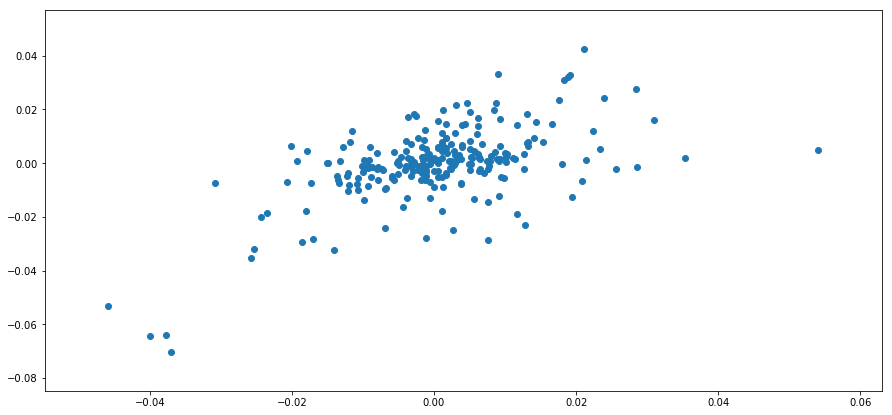

In [2]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 7))
plt.scatter(new['asset2_r'], new['benchmark_r'])
plt.show()

In [3]:
## Beta值计算
Beta_asset2 = np.corrcoef(new['asset2_r'],new['benchmark_r'])[0,1]*new['asset2_r'].std()/new['benchmark_r'].std()
print Beta_asset2

0.505352553688


## 用图形显示CAPM模型

In [4]:
import statsmodels.api as sm

model = sm.OLS(new['asset1_r'], sm.add_constant(new['benchmark_r']))

result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               asset1_r   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     816.4
Date:                Sat, 17 Jun 2017   Prob (F-statistic):           2.39e-79
Time:                        13:51:14   Log-Likelihood:                 917.83
No. Observations:                 243   AIC:                            -1832.
Df Residuals:                     241   BIC:                            -1825.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        9.949e-05      0.000      0.279      0.781      -0.001       0.001
benchmark_r     0.7358      0.026     28.573      0.000       0.685       0.787
==============================================================================
Omnibus:                       26.382   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.894
Skew:                           0.462   Prob(JB):                     1.81e-15
Kurtosis:                       5.419   Cond. No.                         72.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

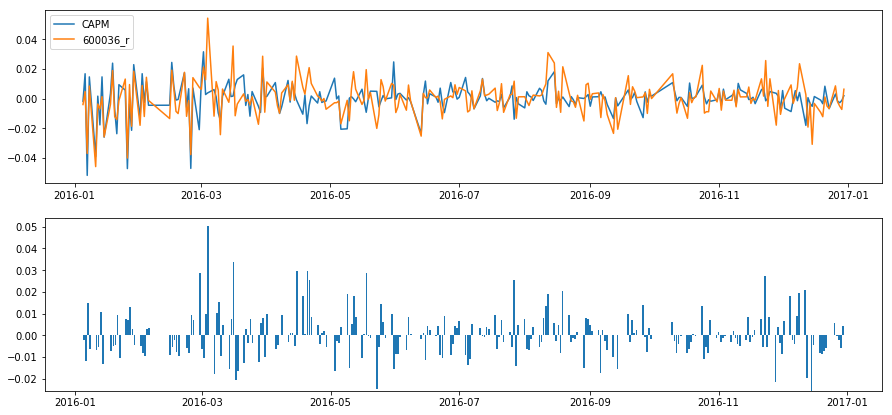

In [12]:
CAPM = result.params[0] + result.params[1]*new['benchmark_r']
Diff = new['asset2_r'] - CAPM 

fig = plt.figure(figsize=(15, 7))
plt.subplot(2,1,1)
plt.plot(CAPM, label='CAPM')
plt.plot(new['asset2_r'], label='600036_r')
plt.legend(loc='upper left')
plt.subplot(2,1,2)
plt.bar(new.index, Diff)
plt.show()

## 如何对模型做方差分析？
### 单因素方差分析：

计算单大盘指数的因素(PR)对股票收益率的影响是否显著。

### 析因素方差分析：

计算各因素对股票收益率的影响(PR)是否显著，并计算其他因子间的影响是否有显著依赖。

In [75]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
# 单因素分析
var_model = ols('asset2_r~benchmark_r', data=new).fit()
table = anova_lm(var_model)

#析因素分析
var_model1 = ols('asset2_r~asset1_r*benchmark_r', data=new).fit()
table1 = anova_lm(var_model1)

print table
print table1

                df    sum_sq   mean_sq          F        PR(>F)
benchmark_r    1.0  0.011906  0.011906  121.08287  4.380746e-23
Residual     241.0  0.023698  0.000098        NaN           NaN
                         df    sum_sq   mean_sq           F        PR(>F)
asset1_r                1.0  0.016777  0.016777  216.879682  2.278162e-35
benchmark_r             1.0  0.000097  0.000097    1.251745  2.643427e-01
asset1_r:benchmark_r    1.0  0.000241  0.000241    3.120282  7.859988e-02
Residual              239.0  0.018489  0.000077         NaN           NaN


## 作业
用其他股票做CAPM模型